In [1]:
import torch
import pandas as pd
import numpy as np


df=pd.read_csv(r'AAPL.csv')   # CHANGE THE PATH OF FILE

df1=df.reset_index()['close']
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1=torch.tensor(df1, dtype=torch.float32)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [22]:
import torch
from torch import nn

class NN_layer(nn.Module):
    def __init__(self, input_size, output_size, layer_feature, hidden_layer_sizes, choice='relu'):
        super(NN_layer, self).__init__()
        self.layer_feature = layer_feature
        self.hidden_layer_sizes = hidden_layer_sizes

        # Activation functions
        # self.act = nn.ModuleDict({
        #     'selu': nn.SELU(),
        #     'relu': nn.ReLU(),
        #     'leakyrelu': nn.LeakyReLU(),
        #     'tanh': nn.Tanh(),
        #     'sigmoid': nn.Sigmoid(),
        # })

        self.deep_nn = nn.ModuleList()
        
        # Adding hidden layers based on the provided hidden_layer_sizes list
        for i, hidden_layer_size in enumerate(hidden_layer_sizes):
            self.deep_nn.add_module(f'linear_{i}', nn.Linear(input_size, hidden_layer_size,bias=False))
            input_size = hidden_layer_size  # Set input size for the next layer
        
        # Output layer
        self.deep_nn.add_module('linear', nn.Linear(hidden_layer_sizes[-1], output_size,bias=False))
    
    def forward(self, x, previous_output=None):
        
        print(x)
        intermediate_outputs = None  
        
        
        if previous_output is None:
            previous_output = torch.rand((1, self.hidden_layer_sizes[self.layer_feature]), dtype=torch.float32)*.01

        
        concat_input = torch.cat((x, previous_output), dim=1)  
        for i, layer in enumerate(self.deep_nn):
            concat_input = layer(concat_input)
           
                
            
            if isinstance(layer, nn.Linear) and i < len(self.deep_nn) - 1:
                if i == self.layer_feature:  
                    # Capture intermediate output and apply tanh
                    concat_input = torch.selu(concat_input)
                    intermediate_outputs = torch.tanh(concat_input.detach())  
                else:
                    concat_input = torch.selu(concat_input)  

        
        return concat_input, intermediate_outputs

In [44]:
import torch
from torch import nn, optim

def run_network_with_batches(model, input_data, look_back, learning_rate=0.1):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    num_samples = input_data.shape[0]
    losses = []  # To store loss values for plotting

    # Initialize intermediate outputs
    previous_intermediate_output = torch.zeros((1, model.hidden_layer_sizes[model.layer_feature]), dtype=torch.float32) * 0.1

    predict = []

    for batch_start in range(num_samples - look_back):
        print('batch_No.======:',batch_start  )
        X_train_batch_input = input_data[batch_start:batch_start + look_back - 1].float()
        batch_target = input_data[batch_start + look_back].unsqueeze(0).float()

        intermediate_outputs = previous_intermediate_output.clone()

        # Forward pass through the network
        for i in range(X_train_batch_input.shape[0]):
            element_input = X_train_batch_input[i].unsqueeze(0)

            # Forward pass through the network, update intermediate_outputs for the next element
            element_output, new_intermediate_outputs = model(element_input, intermediate_outputs)
            intermediate_outputs = new_intermediate_outputs

        # Append the output as a tensor
        predict.append(element_output.detach())  # Keep it as a PyTorch tensor

        # Print the output for debugging
        print('output ======', element_output.detach().numpy())  # Debugging output

        # Calculate the loss
        element_loss = criterion(element_output, batch_target)

        # Backpropagation and optimizer step
        if batch_start <= 700:  # Make sure the condition allows sufficient training
            optimizer.zero_grad()
            element_loss.backward()
            optimizer.step()

        
        print("Gradients:", [param.grad for param in model.parameters()])

        losses.append(element_loss.item())
        previous_intermediate_output = intermediate_outputs

    return losses, predict


In [45]:
model=NN_layer(input_size=5, output_size=1, layer_feature=3, hidden_layer_sizes=[20, 10, 5, 4], choice='relu')
# Assuming df1 is the input data tensor
X_train = torch.tensor(df1[0:1000], dtype=torch.float32)  # Ensure X_train is float32
look_back=7
# Now you can run the function like this:
losses, predict = run_network_with_batches(model, X_train, look_back=look_back, learning_rate=0.1)

C:\Users\keshg\AppData\Local\Temp\ipykernel_3356\1737430702.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(df1[0:1000], dtype=torch.float32)  # Ensure X_train is float32


batch_No.======: 0
tensor([[0.1761]])
tensor([[0.1750]])
tensor([[0.1686]])
tensor([[0.1697]])
tensor([[0.1673]])
tensor([[0.1679]])
output ====== [[-0.01237033]]
Gradients: [tensor([[-6.6018e-03, -3.0566e-04,  8.7694e-04, -2.9512e-04, -4.5750e-04],
        [ 5.5115e-04,  2.5518e-05, -7.3211e-05,  2.4638e-05,  3.8194e-05],
        [ 1.0155e-02,  4.7015e-04, -1.3489e-03,  4.5394e-04,  7.0371e-04],
        [ 8.4829e-03,  3.9275e-04, -1.1268e-03,  3.7921e-04,  5.8786e-04],
        [-7.8292e-03, -3.6249e-04,  1.0400e-03, -3.4999e-04, -5.4256e-04],
        [ 2.0516e-03,  9.4990e-05, -2.7253e-04,  9.1715e-05,  1.4218e-04],
        [ 3.3604e-04,  1.5559e-05, -4.4638e-05,  1.5022e-05,  2.3288e-05],
        [ 6.8149e-03,  3.1553e-04, -9.0524e-04,  3.0465e-04,  4.7227e-04],
        [-2.8271e-04, -1.3089e-05,  3.7553e-05, -1.2638e-05, -1.9592e-05],
        [ 5.1531e-03,  2.3859e-04, -6.8450e-04,  2.3036e-04,  3.5711e-04],
        [-2.0568e-03, -9.5227e-05,  2.7321e-04, -9.1944e-05, -1.4253e-04],


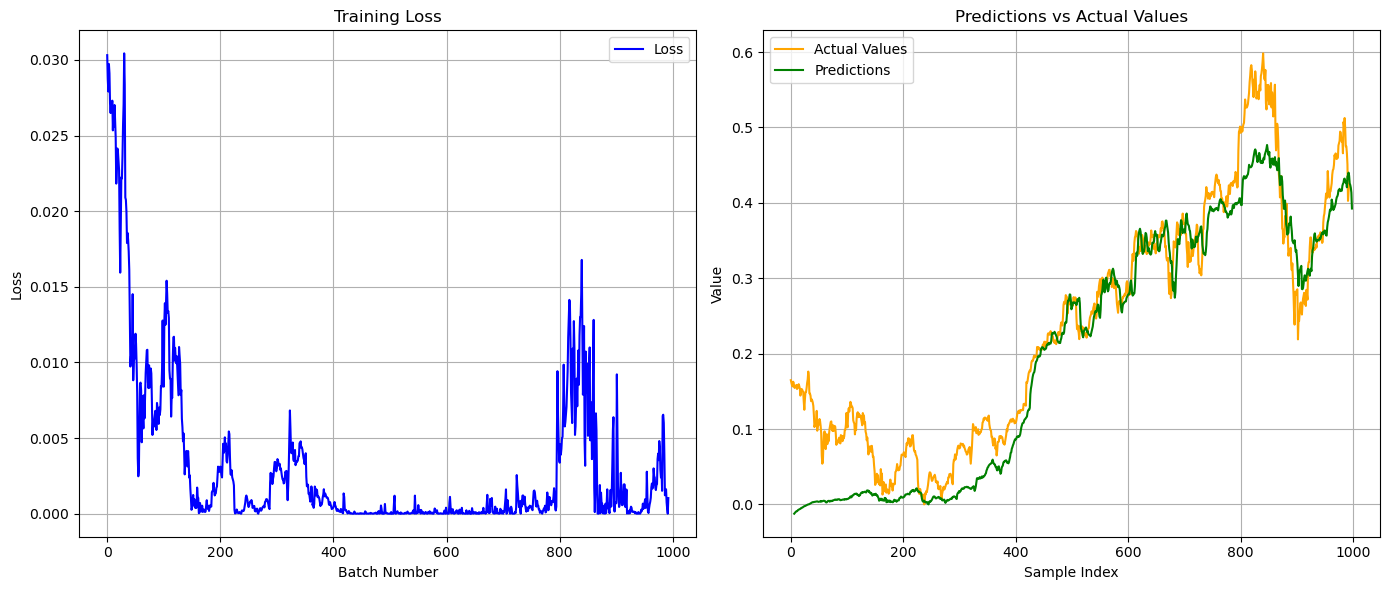

In [46]:
import matplotlib.pyplot as plt

# Run the training function
#losses, predict = run_network_with_batches(model, X_train, look_back=look_back, learning_rate=.01)

# Prepare the data for plotting
# Convert predictions and actual values to the appropriate format for plotting
predict = torch.cat(predict).detach().numpy()  # Detach and convert to numpy array
actual_values = X_train[look_back-1:].detach().numpy()  # Get actual values corresponding to predictions
losses = torch.tensor(losses).detach().numpy()  # Convert losses to numpy for plotting

# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot the predictions vs actual values
plt.subplot(1, 2, 2)
plt.plot(actual_values, label='Actual Values', color='orange')
plt.plot(range(look_back - 1, look_back - 1 + len(predict)), predict, label='Predictions', color='green')
plt.title('Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


In [47]:
import torch
from torch import nn

def run_network_for_testing(model, input_data, look_back):
    # Switch model to evaluation mode
    model.eval()
    
    num_samples = input_data.shape[0]
    losses = []  # To store loss values for testing
    criterion = nn.MSELoss()  # Use the same loss function as in training

    previous_intermediate_output = torch.zeros((1, model.hidden_layer_sizes[model.layer_feature]), dtype=torch.float32) * 0.1
    predict = []

    with torch.no_grad():  # Disable gradient calculation for testing
        for batch_start in range(num_samples - look_back):
            print('Test batch_No.======', batch_start)
            
            # Prepare input batch
            X_test_batch_input = input_data[batch_start:batch_start + look_back - 1].float()
            batch_target = input_data[batch_start + look_back].unsqueeze(0).float()

            intermediate_outputs = previous_intermediate_output.clone()

            # Forward pass through the network for each element in the batch
            for i in range(X_test_batch_input.shape[0]):
                element_input = X_test_batch_input[i].unsqueeze(0)

                # Get the output without backpropagation
                element_output, new_intermediate_outputs = model(element_input, intermediate_outputs)
                intermediate_outputs = new_intermediate_outputs

            # Append the output as a tensor
            predict.append(element_output.detach())  # Keep it as a PyTorch tensor

            # Print the output for debugging
            print('Test output ======', element_output.detach().numpy())

            # Calculate loss without updating the model
            element_loss = criterion(element_output, batch_target)

            # Store the loss value
            losses.append(element_loss.item())
            previous_intermediate_output = intermediate_outputs

    return losses, predict


In [48]:
#model=NN_layer(input_size=5, output_size=1, layer_feature=3, hidden_layer_sizes=[20, 10, 5, 4], choice='relu')
# Assuming df1 is the input data tensor
input_data= torch.tensor(df1[1000:], dtype=torch.float32)  # Ensure X_train is float32
look_back=7
# Now you can run the function like this:
test_losses, test_predict = run_network_for_testing(model, input_data, look_back)

C:\Users\keshg\AppData\Local\Temp\ipykernel_3356\1741566915.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data= torch.tensor(df1[1000:], dtype=torch.float32)  # Ensure X_train is float32


Test batch_No.====== 0
tensor([[0.4211]])
tensor([[0.4165]])
tensor([[0.3916]])
tensor([[0.4064]])
tensor([[0.3903]])
tensor([[0.3771]])
Test output ====== [[0.37496385]]
Test batch_No.====== 1
tensor([[0.4165]])
tensor([[0.3916]])
tensor([[0.4064]])
tensor([[0.3903]])
tensor([[0.3771]])
tensor([[0.3742]])
Test output ====== [[0.37202537]]
Test batch_No.====== 2
tensor([[0.3916]])
tensor([[0.4064]])
tensor([[0.3903]])
tensor([[0.3771]])
tensor([[0.3742]])
tensor([[0.3711]])
Test output ====== [[0.37013885]]
Test batch_No.====== 3
tensor([[0.4064]])
tensor([[0.3903]])
tensor([[0.3771]])
tensor([[0.3742]])
tensor([[0.3711]])
tensor([[0.3675]])
Test output ====== [[0.36816883]]
Test batch_No.====== 4
tensor([[0.3903]])
tensor([[0.3771]])
tensor([[0.3742]])
tensor([[0.3711]])
tensor([[0.3675]])
tensor([[0.3714]])
Test output ====== [[0.36937585]]
Test batch_No.====== 5
tensor([[0.3771]])
tensor([[0.3742]])
tensor([[0.3711]])
tensor([[0.3675]])
tensor([[0.3714]])
tensor([[0.3577]])
Test out

In [37]:
# import torch
# import matplotlib.pyplot as plt

# # Function to convert the predictions (if needed) to PyTorch tensors
# def ensure_tensors(data_list):
#     return [torch.tensor(item) if isinstance(item, np.ndarray) else item for item in data_list]

# # Plotting function for training and testing results
# def plot_results(losses, predict, test_losses, test_predict, X_train, look_back, shift_test=1000):
#     plt.figure(figsize=(12, 8))
    
#     # Convert PyTorch tensors to NumPy for plotting
#     X_train_np = X_train.detach().numpy()
    
#     # Ensure all predictions are tensors
#     predict = ensure_tensors(predict)
#     test_predict = ensure_tensors(test_predict)
    
#     # Combine the list of predictions into a single array
#     train_predict_np = torch.cat(predict).detach().numpy()
#     test_predict_np = torch.cat(test_predict).detach().numpy()
    
#     # Convert losses to NumPy array
#     losses_np = torch.tensor(losses).detach().numpy()
#     test_losses_np = torch.tensor(test_losses).detach().numpy()
    
#     # Plot training and test predictions against the actual values
#     plt.subplot(2, 1, 1)  # 1st plot for actual vs predictions
#     plt.plot(X_train_np, label='Actual Values', color='blue')
    
#     # Shift test predictions along the x-axis
#     train_range = range(len(train_predict_np))
#     test_range = range(shift_test, shift_test + len(test_predict_np))

#     plt.plot(train_range, train_predict_np, label='Train Predictions', color='green')
#     plt.plot(test_range, test_predict_np, label='Test Predictions', color='red')
    
#     plt.title('Actual vs Predictions')
#     plt.legend()

#     # Plot losses
#     plt.subplot(2, 1, 2)  # 2nd plot for losses
#     plt.plot(losses_np, label='Train Losses', color='green')
#     plt.plot(range(shift_test, shift_test + len(test_losses_np)), test_losses_np, label='Test Losses', color='red')
    
#     plt.title('Training and Testing Losses')
#     plt.legend()

#     plt.tight_layout()
#     plt


In [54]:
import plot
import numpy as np


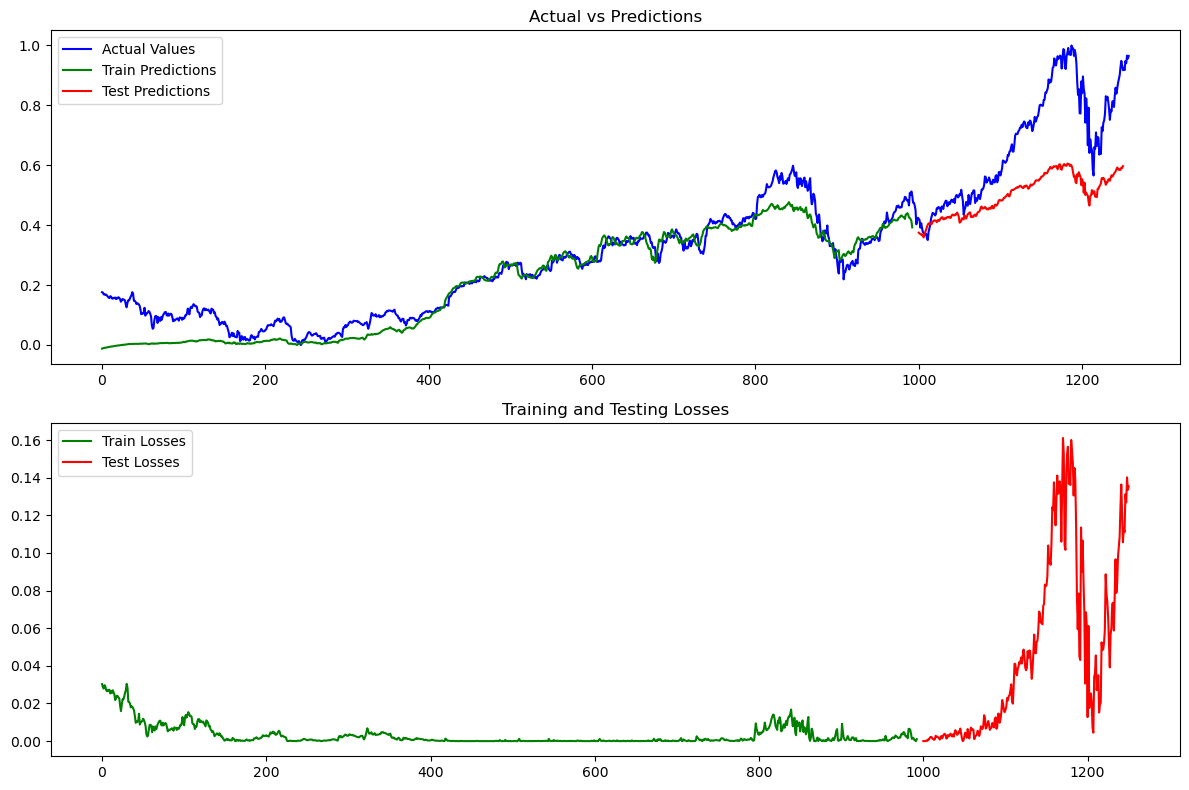

In [69]:
from plot_graph import plot_results
import numpy as np
# Assuming you have the appropriate data for losses, predict, test_losses, test_predict, X_train, look_back
plot_results(losses, predict, test_losses, test_predict, X_train, look_back, shift_test=1000)
